##Синхронизация блока EV3 и ПК

###Windows

Синхронизация происходит по USB.

1. Подключить брик к компьютеру с помощью USB кабеля.
2. После этого на роботе необходимо зайти в `Wireless and Network`, далее в `All Network Connections`, там должно отобразиться подключение Wired, которое нужно подключить (см. картинку)

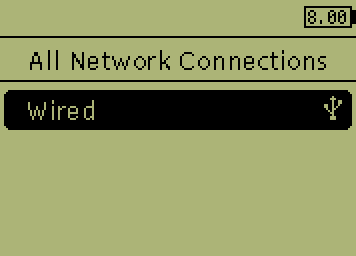


###Linux & MacOS

Синхронизация происходит по Wi-Fi.

Для того чтобы с роботом можно было работать по Wifi, необходим Wifi адаптер, вставляемый в свободное гнездо USB. Робот и компьютер должны быть подключены к одной и той же сети Wifi.

Чтобы подключить робота к Wifi, на брике зайдите в `Wireless and Network`, дальше откройте `Wi-Fi` и нажмите `Start Scan`. После того как закончится поиск сетей, выбираете вашу сеть, нажмите `Connect` и введите пароль. После подключения в левом верхнем углу экрана брика появится его локальный IP-адрес.


##Работа с файловой системой EV3

###Windows

Для работы с EV3 потребуется установить программу `WinSCP`.

1. Открываем программу WinSCP. В открывшемся диалоговом окне в качестве имени хоста используем `ev3dev`, в качестве имени пользователя `robot`, пароль `maker`. Подключение можно сохранить.
2. Откроется окно, в котором можно удобно работать с файлами внутри робота. При необходимости можно открыть консоль EV3.

###Linux

In [ ]:
# установим sshfs
sudo apt-get install sshfs
# создадим директорию, куда будет монтироваться робот
mkdir <путь до создаваемой директории>
# монтирование. ip адрес робота можно найти на экране EV3 в углу сверху
sshfs robot@(robot IP):/home/robot/ /<путь до созданной директории>
# пароль: maker
# В примонтированной папке хранятся все файлы, находящиеся в памяти робота.


###MacOS

Работа просиходит через терминал.

Вариант 1: Монтировка директории

Не тестировано

In [ ]:
# установим brew
/usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"
# установим FUSE и SSHFS
brew cask install osxfuse
brew install sshfs
# создадим директорию, куда будет монтироваться робот
mkdir <путь до создаваемой директории>
# монтирование. ip адрес робота можно найти на экране EV3 в углу сверху
sshfs robot@(robot IP):/home/robot/ /<путь до созданной директории>
# пароль: maker
# В примонтированной папке хранятся все файлы, находящиеся в памяти робота.

Вариант 2: Копирование файла с ПК на робота

В данном варианте работа над кодом производиться в любом удобном для вас редакторе кода или IDE, после чего нужный файл просто копируется на робота.

In [ ]:
# копирование
scp -v <путь до файла> robot@(robot IP):/home/robot/ #используйте флаг -rv вместо -v, если нужно скопировать директорию

Сскопировать файлы с данными с EV3 на компьютер можно этой же командой:

In [ ]:
scp -v robot@(robot IP):/home/robot/<путь до файла или директории> <путь до директории, куда хотите скопировать> #используйте флаг -rv вместо -v, если нужно скопировать директорию

## Запуск программы для управления роботом

###Windows

В появившемся после открытия программы `WinSCP` окне, откройте терминал (значок консоли в верхнем горизонтальном меню). Команды вводятся в соответствующей строке (см. пример на картинке ниже).

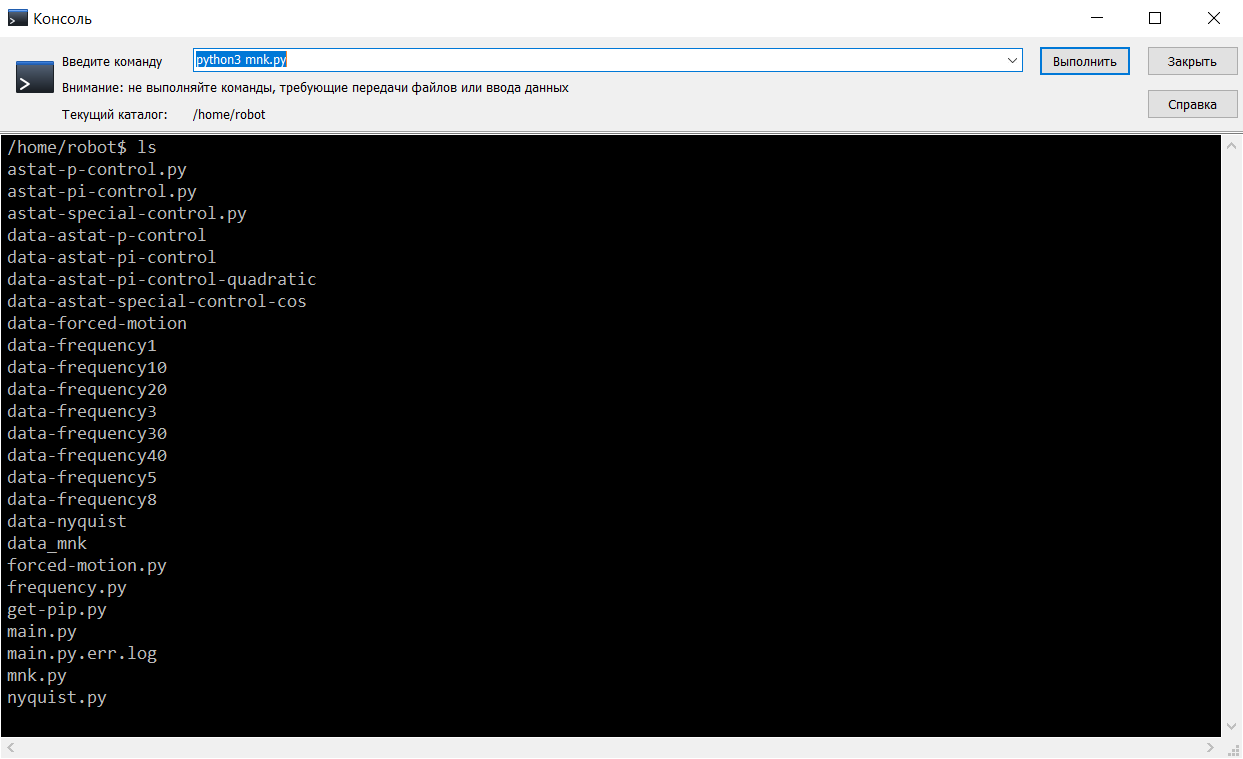

In [ ]:
# команда для запуска управляющего скрипта
python3 <имя файла.py>

## Linux & MacOS


Чтобы запустить программу на исполнение на работе,, потребуется подключиться к нему с помощью `ssh`.

In [ ]:
ssh robot@<robot ip>
# потребуется ввести пароль от робота (maker)
python3 <имя файла.py> # запускаем файл для управления роботом


## Пример кода для работы с EV3
Данный код позволяет подавать подавать на движок постоянное управляющее воздействие, получать данные и записывать их в файл.

In [ ]:
#!/usr/bin/env python3
from ev3dev.ev3 import LargeMotor
from ev3dev2.power import PowerSupply
import time
import os
import shutil

# Класс для получения данных о заряде батареи
volts = PowerSupply()
# Класс для взаимодействия с двигателем
motorA = LargeMotor('outA')

# Создаем папочку для данных
if os.path.exists('/home/robot/data_mnk'):
    shutil.rmtree('/home/robot/data_mnk')

os.makedirs('/home/robot/data_mnk')

try:
    for i in range(5):
        # Задаем входное напряжение, которое будет меняться от 20% до 100% с шагом 20
        U = (i + 1)*20
        # Сохраняем начальное время
        start_time = time.time()
        # Сохраняем начальную позицию
        start_pos = motorA.position
        # Подаем на мотор напряжение U
        motorA.run_direct(duty_cycle_sp=U)
        # В течение двух секунд записываем в файл данные в формате: <time,angle,speed>
        while (time.time() - start_time) < 2:
            # Конструкция 'with open() as f' означает то же самое, что и 'f = open(); ...; f.close()'
            with open('data_mnk/mnk_data'+str(U), "a") as f:
                print(str(time.time() - start_time) + ',' + str(motorA.position - start_pos) + ',' + str(motorA.speed))
                f.write(str(time.time() - start_time) + ',' + str(motorA.position - start_pos) + ',' + str(motorA.speed) + '\n')
        # Останавливаем мотор
        motorA.run_direct(duty_cycle_sp=0)
        time.sleep(1)
        # Повторяем то же самое для отрицательного напряжения
        start_time = time.time()
        start_pos = motorA.position
        motorA.run_direct(duty_cycle_sp=-U)
        while (time.time() - start_time) < 2:
            with open('data_mnk/mnk_data'+str(-U), "a") as f:
                print(str(time.time() - start_time) + ',' + str(motorA.position - start_pos) + ',' + str(motorA.speed))
                f.write(str(time.time() - start_time) + ',' + str(motorA.position - start_pos) + ',' + str(motorA.speed) + '\n')
        motorA.run_direct(duty_cycle_sp=0)
        time.sleep(1)
except Exception as e:
    raise e
finally:
    # Останавливаем мотор в случае ошибок в коде
    motorA.stop(stop_action='brake')

# Выводим заряд батареи, то есть реальное напряжение в вольтах, которое подается на двигатель при 100% поданной на него мощности
print("Volts: " + str(volts.measured_volts))

## Пример кода для Matlab
Данный код обрабатывает файлы с данными, полученные раннее, и считает коэффиенты k и Tm для ДПТ с помощью метода наименьших квадратов (МНК).

In [ ]:
k_avg = 0;
Tm_avg = 0;
battery_power = 6.8424; % Заряд батареи, полученный с брика
for i = -5:5
    if i ~= 0
        data = readmatrix("<путь до файла>/mnk_data"+i*20);
        time = data(:,1);
        angle = data(:,2)*pi/180; % перевод из градусов в радианы
        speed = data(:,3)*pi/180; % перевод из градусов в радианы
        par0=[2;0.077]; % предполагаемые значения k и Tm соответсвенно
        U_volts = i*20*battery_power/100;
        fun_angle = @(par,time)U_volts*par(1)*(time - par(2)*(1 - exp(-time/par(2)))); %функция для апроксимации по углу
        par = lsqcurvefit(fun_angle,par0,time,angle); % апроксимация с помощью МНК
        k = par(1);
        Tm = par(2);
        k_avg = k + k_avg;
        Tm_avg = Tm + Tm_avg;
    end
end
Tm_avg = Tm_avg/10
k_avg = k_avg/10

##Полезные ссылки
[API для EV3](https://ev3dev-lang.readthedocs.io/projects/python-ev3dev/en/stable/spec.html)


